# IT-507 Advanced Image Processing 
## Project Title: Guided Filter
### Author: 202011004: Kishan Vaishnani, 20201132: Dhyanil Mehta

In [1]:
!sudo apt-get update
!sudo apt install -y libgtk2.0-dev

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic InRelease [242 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:5 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,119 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security/multiverse amd64 Packages [24.7 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [399 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,410 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 Packages [186 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic/restricted amd64 Packages [13.5 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic/main amd64 Packages [1,344 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic/universe amd64 Packages [11.3 MB]
Get:13 http://archive.ubu

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Useful functions

In [3]:
## Return if the input image is gray or not.
def _isGray(I):
    return len(I.shape) == 2

## Convert image into float32 type.
def to32F(img):
    if img.dtype == np.float32:
        return img
    return (1.0 / 255.0) * np.float32(img)

## Guided filter for black and white

In [4]:
## Guided filter for gray guidance image.
class GuidedFilterGray:
    #  @param I Input gray guidance image.
    #  @param radius Radius of Guided Filter.
    #  @param epsilon Regularization term of Guided Filter.
    #  I: Guided image
    #  R: Radius for the box filter
    #  Epsilon: regularization parameter
    #  p: Input image
    #  q: Output image 
    def __init__(self, I, radius=5, epsilon=0.4):
        self._radius = 2 * radius + 1
        self._epsilon = epsilon
        self._I = to32F(I)
        self._initFilter()

    ## Apply filter for the input image.
    #  @param p Input image for the filtering.
    def filter(self, p):
        p_32F = to32F(p)
        ab = self._computeCoefficients(p_32F)
        return self._computeOutput(ab, self._I)

    def _initFilter(self):
        I = self._I
        r = self._radius
        self._I_mean = cv2.blur(I, (r, r))
        I_mean_sq = cv2.blur(I ** 2, (r, r))
        self._I_var = I_mean_sq - self._I_mean ** 2

    def _computeCoefficients(self, p):
        r = self._radius
        p_mean = cv2.blur(p, (r, r))
        I_p_corr = cv2.blur(self._I * p, (r, r))
        p_cov = I_p_corr - self._I_mean * p_mean
        a = p_cov / (self._I_var + self._epsilon)
        b = p_mean - a * self._I_mean
        a_mean = cv2.blur(a, (r, r))
        b_mean = cv2.blur(b, (r, r))
        return a_mean, b_mean

    def _computeOutput(self, ab, I):
        a_mean, b_mean = ab
        return a_mean * I + b_mean

## Guided filter for color image 

In [5]:
## Guided filter for gray guidance image.
class GuidedFilterColor:
    #  @param I Input gray guidance image.
    #  @param radius Radius of Guided Filter.
    #  @param epsilon Regularization term of Guided Filter.
    #  I: Guided image
    #  R: Radius for the box filter
    #  Epsilon: regularization parameter
    #  p: Input image
    #  q: Output image 
    def __init__(self, I, radius=5, epsilon=0.4):
        self._radius = 2 * radius + 1
        self._epsilon = epsilon
        self._I = to32F(I)
        self._initFilter()

    ## Apply filter for the input image.
    #  @param p Input image for the filtering.
    def filter(self, p):
        p_32F = to32F(p)

        cs = p.shape[2]
        q = np.array(p_32F)

        for ci in range(cs):
            q[:, :, ci] = self._filterGray(p_32F[:, :, ci])
        return q
        
    def _filterGray(self, p):
        ab = self._computeCoefficients(p)
        return self._computeOutput(ab, self._I)

    def _initFilter(self):
        I = self._I
        r = self._radius
        eps = self._epsilon

        Ir, Ig, Ib = I[:, :, 0], I[:, :, 1], I[:, :, 2]

        self._Ir_mean = cv2.blur(Ir, (r, r))
        self._Ig_mean = cv2.blur(Ig, (r, r))
        self._Ib_mean = cv2.blur(Ib, (r, r))

        Irr_var = cv2.blur(Ir ** 2, (r, r)) - self._Ir_mean ** 2 + eps
        Irg_var = cv2.blur(Ir * Ig, (r, r)) - self._Ir_mean * self._Ig_mean
        Irb_var = cv2.blur(Ir * Ib, (r, r)) - self._Ir_mean * self._Ib_mean
        Igg_var = cv2.blur(Ig * Ig, (r, r)) - self._Ig_mean * self._Ig_mean + eps
        Igb_var = cv2.blur(Ig * Ib, (r, r)) - self._Ig_mean * self._Ib_mean
        Ibb_var = cv2.blur(Ib * Ib, (r, r)) - self._Ib_mean * self._Ib_mean + eps

        Irr_inv = Igg_var * Ibb_var - Igb_var * Igb_var
        Irg_inv = Igb_var * Irb_var - Irg_var * Ibb_var
        Irb_inv = Irg_var * Igb_var - Igg_var * Irb_var
        Igg_inv = Irr_var * Ibb_var - Irb_var * Irb_var
        Igb_inv = Irb_var * Irg_var - Irr_var * Igb_var
        Ibb_inv = Irr_var * Igg_var - Irg_var * Irg_var

        I_cov = Irr_inv * Irr_var + Irg_inv * Irg_var + Irb_inv * Irb_var
        Irr_inv /= I_cov
        Irg_inv /= I_cov
        Irb_inv /= I_cov
        Igg_inv /= I_cov
        Igb_inv /= I_cov
        Ibb_inv /= I_cov

        self._Irr_inv = Irr_inv
        self._Irg_inv = Irg_inv
        self._Irb_inv = Irb_inv
        self._Igg_inv = Igg_inv
        self._Igb_inv = Igb_inv
        self._Ibb_inv = Ibb_inv

    def _computeCoefficients(self, p):
        r = self._radius
        I = self._I
        Ir, Ig, Ib = I[:, :, 0], I[:, :, 1], I[:, :, 2]

        p_mean = cv2.blur(p, (r, r))

        Ipr_mean = cv2.blur(Ir * p, (r, r))
        Ipg_mean = cv2.blur(Ig * p, (r, r))
        Ipb_mean = cv2.blur(Ib * p, (r, r))

        Ipr_cov = Ipr_mean - self._Ir_mean * p_mean
        Ipg_cov = Ipg_mean - self._Ig_mean * p_mean
        Ipb_cov = Ipb_mean - self._Ib_mean * p_mean

        ar = self._Irr_inv * Ipr_cov + self._Irg_inv * Ipg_cov + self._Irb_inv * Ipb_cov
        ag = self._Irg_inv * Ipr_cov + self._Igg_inv * Ipg_cov + self._Igb_inv * Ipb_cov
        ab = self._Irb_inv * Ipr_cov + self._Igb_inv * Ipg_cov + self._Ibb_inv * Ipb_cov
        b = p_mean - ar * self._Ir_mean - ag * self._Ig_mean - ab * self._Ib_mean

        ar_mean = cv2.blur(ar, (r, r))
        ag_mean = cv2.blur(ag, (r, r))
        ab_mean = cv2.blur(ab, (r, r))
        b_mean = cv2.blur(b, (r, r))

        return ar_mean, ag_mean, ab_mean, b_mean

    def _computeOutput(self, ab, I):
        ar_mean, ag_mean, ab_mean, b_mean = ab

        Ir, Ig, Ib = I[:, :, 0], I[:, :, 1], I[:, :, 2]

        q = (ar_mean * Ir +
             ag_mean * Ig +
             ab_mean * Ib +
             b_mean)

        return q

## Noise removal in black and white image

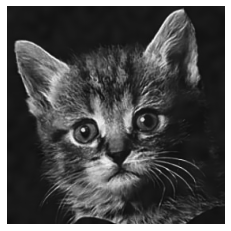

In [22]:

I = cv2.imread("cat.png", 0)

plt.figure()
# plt.title("Guidance Image")
plt.imshow(I, cmap="gray")
plt.axis('off')
plt.savefig("./output/cat_guidance.png",bbox_inches='tight', transparent = True, pad_inches = 0)

h, w = I.shape
p = np.float32(I + 50 * np.random.randn(h, w))
p = np.clip(p, 0.0, 255.0)

plt.figure()
# plt.title("Noisy Input Image")
plt.imshow(p, cmap="gray")
plt.axis('off')
plt.savefig("./output/cat_input.png",bbox_inches='tight', transparent = True, pad_inches = 0)

obj=GuidedFilterGray(I, radius=5, epsilon=0.0001)
q = obj.filter(p)

plt.figure()
# plt.title("Guided filter applied image")
plt.imshow(q, cmap="gray")
plt.axis('off')
plt.savefig("./output/cat_gf.png",bbox_inches='tight', transparent = True, pad_inches = 0)

## Noise removal in RGB image

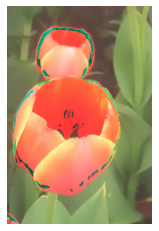

In [50]:
I = cv2.imread("tulips.png")
I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)

plt.figure()
# plt.title("Guidance Image")
plt.imshow(np.uint8(I))
plt.axis('off')
plt.savefig("./output/tulip_guidance.png",bbox_inches='tight', transparent = True, pad_inches = 0)

h, w, cs = I.shape
p = I + 100 * np.random.rand(h, w, cs)
p = np.clip(p, 0.0, 255.0)

plt.figure()
# plt.title("Noisy Image")
plt.imshow(np.uint8(p))
plt.axis('off')
plt.savefig("./output/tulip_input.png",bbox_inches='tight', transparent = True, pad_inches = 0)

obj=GuidedFilterColor(I, radius=20, epsilon=0.002)
q = obj.filter(p)

plt.figure()
# plt.title("Guided filter applied image")
plt.imshow(np.uint8(q * 255.0))
plt.axis('off')
plt.savefig("./output/tulip_gf.png",bbox_inches='tight', transparent = True, pad_inches = 0)

## Structure-Transferring Filtering

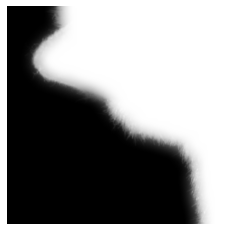

In [24]:
I = cv2.imread("toy.png")
I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)

plt.figure()
# plt.title("Guidance Image")
plt.imshow(np.uint8(I))
plt.axis('off')
plt.savefig("./output/toy_guidance.png",bbox_inches='tight', transparent = True, pad_inches = 0)

p = cv2.imread("toy-mask.png")
p = cv2.cvtColor(p, cv2.COLOR_BGR2RGB)

plt.figure()
# plt.title("Noisy Image")
plt.imshow(np.uint8(p))
plt.axis('off')
plt.savefig("./output/toy_input.png",bbox_inches='tight', transparent = True, pad_inches = 0)

obj=GuidedFilterColor(I, radius=20, epsilon=0.099)
q = obj.filter(p)

plt.figure()
# plt.title("Guided filter applied image")
plt.imshow(np.uint8(q * 255.0))
plt.axis('off')
plt.savefig("./output/toy_gf.png", bbox_inches = 'tight', transparent = True, pad_inches = 0)

## Flash removal filter

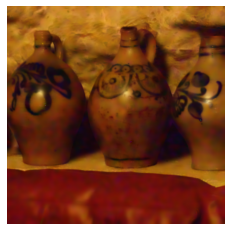

In [27]:
I = cv2.imread("cave-flash.png")
I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)

plt.figure()
# plt.title("Guidance Image")
plt.imshow(np.uint8(I))
plt.axis('off')
plt.savefig("./output/cave_guidance.png", bbox_inches = 'tight', transparent = True, pad_inches = 0)

p = cv2.imread("cave-noflash.png")
p = cv2.cvtColor(p, cv2.COLOR_BGR2RGB)

plt.figure()
# plt.title("Noisy Image")
plt.imshow(np.uint8(p))
plt.axis('off')
plt.savefig("./output/cave_input.png", bbox_inches = 'tight', transparent = True, pad_inches = 0)

obj=GuidedFilterColor(I, radius=5, epsilon=0.004)
q = obj.filter(p)

plt.figure()
# plt.title("Guided filter applied image")
plt.imshow(np.uint8(q * 255.0))
plt.axis('off')
plt.savefig("./output/cave_gf.png", bbox_inches = 'tight', transparent = True, pad_inches = 0)

## Image enhancement

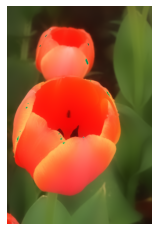

In [42]:
I = cv2.imread("tulips.png")
I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)

plt.figure()
# plt.title("Guidance Image")
plt.imshow(I)
plt.axis('off')
plt.savefig("./output/tulips_guidance.png", bbox_inches = 'tight', transparent = True, pad_inches = 0)

p = cv2.imread("tulips-smoothed.png")
p = cv2.cvtColor(p, cv2.COLOR_BGR2RGB)

plt.figure()
# plt.title("Smoothed Image")
plt.imshow(p)
plt.axis('off')
plt.savefig("./output/tulips_input.png", bbox_inches = 'tight', transparent = True, pad_inches = 0)

obj=GuidedFilterColor(I, radius=25, epsilon=0.009)
q = obj.filter(p)
q = np.uint8(q * 255.0)

plt.figure()
# plt.title("Guided filter applied image")
plt.imshow(q)
plt.axis('off')
plt.savefig("./output/tulips_gf.png", bbox_inches = 'tight', transparent = True, pad_inches = 0)